<a href="https://colab.research.google.com/github/tjaustria4/Google-Colab-Try/blob/main/cuda_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CoE 197Z - Deep Learning Completion Project**

---


Theodore J. Austria

2015-05476

---



The main code that was used here was from the site: *https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html* by the author **Sasank Chilamkurthy**.

I added my code for preparing the data to be fed into the model. I modified some of the code to fit for the required task. The format 2 of the SVHN core was used in this code.






In [26]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import scipy.io as sio

I uploaded the format 2 data set which is the .mat files into my google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Checked for the list of models.

In [ ]:
[model for model in dir(models)]

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

I loaded the two .mat files(format 2 of the SVHN core) using the scipy.io library.

Based from what I have researched and learned from the resources online, the structure of the root folder for the data set must be in the form:

    root/
      train/
        labels/
          image1.jpg
          ...
      val/
        labels/
          image2.jpg
          ...
The code below extracts the information from the .mat files which are:


*   images with size 32x32
*   corresponding label of the image

Because of the structure of the root folder being like that and the information of the .mat files, I saved the 32x32 pictures to the drive with the following details:

*   Root folder = "SVHN_format2"
*   Labels/Sub-folders of the train folder = "1" ,"2",...,"10"
  *   Contents are the images of the "train_32x32.mat" file

*   Labels/Sub-folders of the val folder = "1" ,"2",...,"10"
  *   Contents are the images of the "test_32x32.mat" file







    

In [ ]:
number_of_files = 0
# load .mat files
train = sio.loadmat('/content/drive/MyDrive/test_32x32.mat')
val = sio.loadmat('/content/drive/MyDrive/train_32x32.mat')

# access to the dict
x_train = train['X'] #images
y_train = train['y'] #labels of the train images
print(len(y_train))
x_val = val['X'] #images
y_val = val['y'] #labels of the val images
print(len(y_val))

# save the images to the train folder with the labels subfolders
for number_of_files in range(len(y_train)-1):
  im = Image.fromarray(x_train[:,:,:,number_of_files])
  im.save('/content/drive/MyDrive/SVHN_format2/train/'+str(int(y_train[number_of_files])) + '/' +str(number_of_files+1) + '.jpg')

number_of_files = 0

# save the images to the val folder with the labels subfolders
for number_of_files in range(len(y_val)-1):
  im = Image.fromarray(x_val[:,:,:,number_of_files])
  im.save('/content/drive/MyDrive/SVHN_format2/val/'+str(int(y_val[number_of_files])) + '/' +str(number_of_files+1) + '.jpg')


26032
73257


In [ ]:
list = os.listdir('/content/drive/MyDrive/SVHN_format2/val/4') # dir is your directory path
number_files = len(list)
print(number_files)

7458


The code below is for the preprocessing of the data. This will create the dataloader to be fed to the model.

In [28]:
  # Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(32),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/SVHN_format2'
#data_dir = '/content/drive/MyDrive/SVHN_small'
#data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Check for the device if cuda or cpu.

In [29]:
print(device)

cpu


Check the details of the nvidia cuda.

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Check is cuda is available.

In [ ]:
torch.cuda.is_available()

True

Check what GPU is used.

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

The code below shows some of the images and their corresponding labels.

The number of images depends on the batch_size.

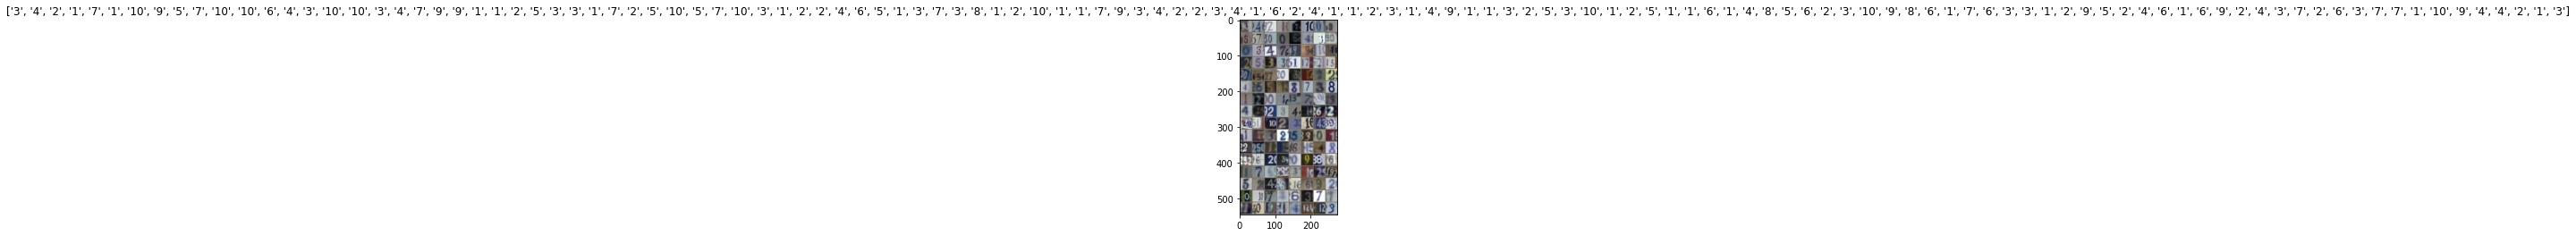

In [30]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

The code below is for the training of the model. 

The number of epochs that I set was 25. 

Throughout the training process, the loss and acc values are shown per epoch. As the epoch further progresses, loss is decreased and acc is increased. This can be shown by the plots.

After the model is trained, the plots of the train loss, train acc, val loss, and val acc are shown.



In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_array_loss = []
    train_array_acc = []
    val_array_loss = []
    val_array_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            #get details for plot
            if phase == 'train':
                train_array_loss.append(epoch_loss)
                train_array_acc.append(epoch_acc)
            if phase == 'val':
                val_array_loss.append(epoch_loss)
                val_array_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    # Print the plots of the loss and acc values for train and val
    #plt.subplot(1,2,1)
    plt.plot(train_array_loss, label = 'Train Loss')
    plt.plot(train_array_acc, label = 'Train Acc')
    plt.legend()
    plt.title('Train data loss and acc')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()
    #plt.subplot(1,2,2)
    plt.plot(val_array_loss, label = 'Val Loss')
    plt.plot(val_array_acc, label = 'Val Acc')
    plt.legend()
    plt.title('Val data loss and acc')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
  

    return model

The function below is for visualization purposes. We can see here the image and the predicted number of that image.

In [32]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **resnet18 model**

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training resnet18 model..
Epoch 0/24
----------
train Loss: 1.1829 Acc: 0.6265
val Loss: 0.6935 Acc: 0.7823

Epoch 1/24
----------
train Loss: 0.5201 Acc: 0.8460
val Loss: 0.5011 Acc: 0.8492

Epoch 2/24
----------
train Loss: 0.3676 Acc: 0.8938
val Loss: 0.4858 Acc: 0.8585

Epoch 3/24
----------
train Loss: 0.2866 Acc: 0.9186
val Loss: 0.5011 Acc: 0.8472

Epoch 4/24
----------
train Loss: 0.2350 Acc: 0.9339
val Loss: 0.4300 Acc: 0.8784

Epoch 5/24
----------
train Loss: 0.1922 Acc: 0.9451
val Loss: 0.4669 Acc: 0.8677

Epoch 6/24
----------
train Loss: 0.1721 Acc: 0.9517
val Loss: 0.4564 Acc: 0.8681

Epoch 7/24
----------
train Loss: 0.0965 Acc: 0.9744
val Loss: 0.3712 Acc: 0.8963

Epoch 8/24
----------
train Loss: 0.0707 Acc: 0.9811
val Loss: 0.3693 Acc: 0.8989

Epoch 9/24
----------
train Loss: 0.0634 Acc: 0.9830
val Loss: 0.3574 Acc: 0.8994

Epoch 10/24
----------
train Loss: 0.0569 Acc: 0.9857
val Loss: 0.3777 Acc: 0.8969

Epoch 11/24
----------
train Loss: 0.0522 Acc: 0.9864
val Lo

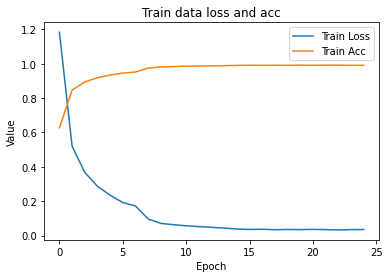

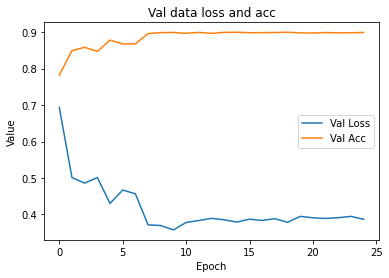

Training complete in 76m 14s
Best val Acc: 0.899913


In [ ]:
print('Training resnet18 model..')
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

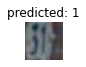

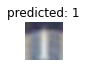

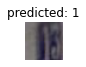

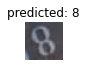

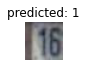

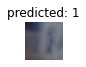

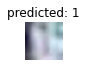

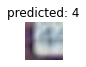

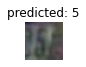

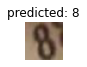

In [ ]:
visualize_model(model_ft)

# **wide_resnet50_2 model**

In [34]:
model_ft = models.wide_resnet50_2(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
print('Training wide_resnet50_2 model..')
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Training wide_resnet50_2 model..


NameError: ignored

In [ ]:
visualize_model(model_ft)

# **resnext50_32x4d model**

In [ ]:
model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training resnext50_32x4d model..
Epoch 0/2
----------
train Loss: 2.4199 Acc: 0.1550
val Loss: 2.4263 Acc: 0.1250

Epoch 1/2
----------
train Loss: 2.3601 Acc: 0.1700
val Loss: 2.4838 Acc: 0.1775

Epoch 2/2
----------
train Loss: 2.2466 Acc: 0.2400
val Loss: 2.7112 Acc: 0.1675



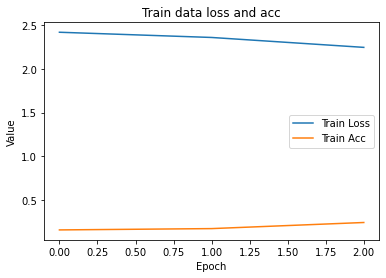

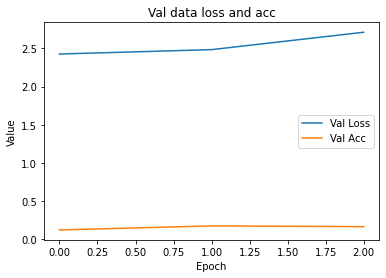

Training complete in 0m 7s
Best val Acc: 0.177500


In [ ]:
print('Training resnext50_32x4d model..')
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3)

In [ ]:
visualize_model(model_ft)